In [1]:
from __future__ import division
import numpy as np
import scipy as sc
from itertools import product
import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import PIL
from numpy import log10
import random
from math import factorial
from scipy.stats import linregress, gaussian_kde
from scipy import stats
from scipy.spatial import distance
import warnings
import pandas as pd
import re
import os
import math
from collections import Counter
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.outliers_influence import summary_table
import statsmodels.api as sm
from scipy.optimize import linear_sum_assignment
import colorsys
from collections import Counter
import scipy.optimize as opt
import scipy.special as sp
import ot
import timeit

warnings.filterwarnings('ignore')

%config InlineBackend.figure_formats = ['svg']
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

pd.set_option('display.max_columns', None)


#          

# Triangle inequality

In [2]:
# Given values for S1, S2, S3
S1 = 0
S2 = 1
S3 = 1

# Calculate absolute differences for RDS
RDS_12 = abs(S1 - S2)
RDS_23 = abs(S2 - S3)
RDS_13 = abs(S1 - S3)

# Check if the triangle inequality holds
LHS = RDS_12 + RDS_23  # Left-hand side of triangle inequality
RHS = RDS_13  # Right-hand side of triangle inequality

# Output results
print("LHS (|S1 - S2| + |S2 - S3|):", LHS)
print("RHS (|S1 - S3|):", RHS)
print("Does the triangle inequality hold?", LHS >= RHS)


LHS (|S1 - S2| + |S2 - S3|): 1
RHS (|S1 - S3|): 1
Does the triangle inequality hold? True


In [3]:
# Earth Mover's Distance (Wasserstein Distance)
def emd_distance(pdf1, pdf2, X1, X2):
    # Normalize PDFs to ensure they sum to 1 exactly.
    sum_pdf1 = np.sum(pdf1)
    sum_pdf2 = np.sum(pdf2)
    
    if sum_pdf1 == 0 or sum_pdf2 == 0:
        raise ValueError("One of the PDFs sums to zero.")
        
    pdf1 = pdf1 / sum_pdf1
    pdf2 = pdf2 / sum_pdf2

    # Replace any NaN values (if any) with zeros.
    pdf1 = np.nan_to_num(pdf1, nan=0.0)
    pdf2 = np.nan_to_num(pdf2, nan=0.0)
    
    # Compute the cost matrix: pairwise absolute differences between points.
    cost_matrix = np.abs(X1[:, None] - X2)  # Shape: (len(X1), len(X2))
    
    # Compute the Earth Mover's Distance (Wasserstein distance).
    emd = ot.emd2(pdf1, pdf2, cost_matrix)
    return emd


# Hellinger Distance
def hellinger_distance(pdf1, pdf2, X1):
    # Hellinger distance calculation
    hellinger = np.sqrt(0.5 * np.sum((np.sqrt(pdf1) - np.sqrt(pdf2))**2) * (X1[1] - X1[0]))
    return hellinger



# Total Variation Distance (TVD)
def tvd_distance(cdf1, cdf2):
    # Total Variation Distance is the maximum of the absolute difference of CDFs
    tvd = np.max(np.abs(cdf1 - cdf2))
    return tvd



# Kolmogorov-Smirnov (KS) Distance
def ks_distance(X1, X2):
    # Use the Kolmogorov-Smirnov test from scipy to get the KS distance
    ks_statistic, _ = ks_2samp(X1, X2)
    return ks_statistic


def energy_distance(pdf1, pdf2, X):
    dx = X[1] - X[0]
    
    # Pairwise distance computation
    energy = 2 * np.sum(np.outer(pdf1, pdf2) * np.abs(X[:, None] - X), axis=(0, 1)) * dx
    energy = energy - np.sum(pdf1[:, None] * pdf1 * np.abs(X[:, None] - X), axis=(0, 1)) * dx
    energy = energy - np.sum(pdf2[:, None] * pdf2 * np.abs(X[:, None] - X), axis=(0, 1)) * dx
    
    return energy


def cramer_von_mises_distance(cdf1, cdf2, X):
    dx = X[1] - X[0]
    
    # Cramér–von Mises distance
    cvm = np.sum((cdf1 - cdf2)**2) * dx
    
    return cvm



In [4]:
import numpy as np
from scipy.stats import beta, ks_2samp
import ot

DS_ls = []
wd_ls = []
emd_ls = []
hld_ls = []
tvd_ls = []
ksd_ls = []
end_ls = []
cvd_ls = []

a1_ls = []
a2_ls = []
b1_ls = []
b2_ls = []

for i in range(1000):
    # Increase number of points to avoid under-sampling
    X_range = np.linspace(0.001, 0.999, 1000)  # Avoiding 0 and 1
    
    # Randomly generate Beta parameters
    a1 = 10**np.random.uniform(-1, 1)
    a2 = 10**np.random.uniform(-1, 1)
    b1 = 10**np.random.uniform(-1, 1)
    b2 = 10**np.random.uniform(-1, 1)

    # Compute PDFs
    pdf1 = beta.pdf(X_range, a1, b1)
    pdf2 = beta.pdf(X_range, a2, b2)

    # Ensure PDFs are valid (no NaNs, no zero-sum issues)
    if np.any(np.isnan(pdf1)) or np.any(np.isnan(pdf2)) or np.sum(pdf1) == 0 or np.sum(pdf2) == 0:
        print(f"Skipping iteration {i} due to invalid PDF values.")
        continue
    
    pdf1 /= np.sum(pdf1)  # Normalize
    pdf2 /= np.sum(pdf2)

    # Compute CDFs for TVD
    cdf1 = beta.cdf(X_range, a1, b1)
    cdf2 = beta.cdf(X_range, a2, b2)

    # Compute distances
    #emd = emd_distance(pdf1.copy(), pdf2.copy(), X_range, X_range)
    hld = hellinger_distance(pdf1, pdf2, X_range)
    tvd = tvd_distance(cdf1, cdf2)
    cvd = cramer_von_mises_distance(cdf1, cdf2, X_range)
    
    sample1 = beta.rvs(a1, b1, size=10000)  # Sample from first Beta
    sample2 = beta.rvs(a2, b2, size=10000)  # Sample from second Beta
    ksd = ks_2samp(sample1, sample2).statistic
    
    end = stats.energy_distance(sample1, sample2)
    wd = stats.wasserstein_distance(sample1, sample2)
    
    # Compute DS
    # mean, i.e., expected value of beta dist = a/(a+b)
    # since max = 1 and min = 0
    # s = (1 - mean)/(1 - 0)
    #   = 1 - mean
    
    m1 = a1 / (a1 + b1)
    m2 = a2 / (a2 + b2)
    
    s1 = 1 - m1
    s2 = 1 - m2
    ds = s1 - s2

    # Store results
    DS_ls.append(ds)
    wd_ls.append(wd)
    #emd_ls.append(emd)
    hld_ls.append(hld)
    tvd_ls.append(tvd)
    ksd_ls.append(ksd)
    end_ls.append(end)
    cvd_ls.append(cvd)

    a1_ls.append(a1)
    a2_ls.append(a2)
    b1_ls.append(b1)
    b2_ls.append(b2)


Energy distance 0.7290111188402346
Wasserstein distance 1.0299350367610893
Cramér–von Mises distance 0.9649538257994652
Hellinger distance  28.224294918006635
Total Variation distance  0.8617193613417823
Kolmogorov-Smirnov distance 0.8631268697434378


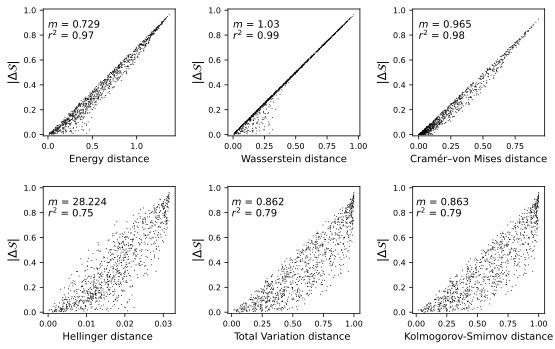

In [5]:

X_lists = [end_ls, 
           wd_ls, 
           cvd_ls,
           hld_ls, 
           tvd_ls, 
           ksd_ls,
          ]


x_labs = ['Energy distance', 
          'Wasserstein distance',
          'Cramér–von Mises distance',
          'Hellinger distance ',
          'Total Variation distance ',
          'Kolmogorov-Smirnov distance',
          ]

fig, axes = plt.subplots(2, 3, figsize=(9, 5.5))  # Create 2x3 subplots

v = 0.0
text_x_vals = [v, v, v, 
               v, v, v]

v = 0.77
text_y_vals = [v, v, v, 
               v, v, v]


for i, x_ls in enumerate(X_lists):
    
    row = i // 3
    col = i % 3
    
    ax = axes[row, col]
    
    ylab = r'$|\Delta\mathcal{S}|$'
    y_ls = np.abs(DS_ls)
    
    if i == 2:
        y_ls = y_ls**2
        ylab = r'$|\Delta\mathcal{S}|$'
    
    ax.scatter(x_ls, y_ls, facecolors='k', s = 1, 
            #edgecolors=None, 
            linewidths=0.0,
            )
    
    
    # Add labels and title
    ax.set_xlabel(x_labs[i], fontsize=10)
    ax.set_ylabel(ylab, fontsize=12)
    ax.tick_params(axis='both', labelsize=8)
    
    slope, intercept, r_val, p_val, std_err = linregress(x_ls, y_ls)
    fitted_vals = slope * np.array(x_ls) + intercept
    
    s = r'$m$ = ' + str(round(slope, 3)) + '\n' + r'$r^2$ = ' + str(round(r_val**2, 2))
    ax.text(text_x_vals[i], text_y_vals[i], s, fontsize=10)
    print(x_labs[i], slope)
    
    ax.set_ylim(-0.01, 1.01)
    
    
fig.patch.set_facecolor('white')
plt.subplots_adjust(hspace=0.4, wspace=0.4)

plt.savefig('Final_Figs/manuscript/Fig3_DistanceMetrics.jpg', bbox_inches='tight', format='jpg', dpi=600)
plt.savefig('Final_Figs/manuscript/Fig3_DistanceMetrics.pdf', bbox_inches='tight', format='pdf', dpi=600)

plt.show()

#

# RUNTIME COMPARISON: SHIFT VS. WD

In [6]:
import numpy as np
import timeit
import matplotlib.pyplot as plt
import scipy.stats as stats


# Histogram sizes to test (growing exponentially)
histogram_sizes = [10, 100, 1000, 10000, 100000] #, 1000000]
iterations = 100  # Number of repetitions for timing
ds_times = []
ws_times = []
ds_cis = []
ws_cis = []

# Measure computation time for Δ𝒮 and Wasserstein at each histogram size
for size in histogram_sizes:
    ds_time_samples = []
    ws_time_samples = []
    
    for _ in range(iterations):
        fq = np.random.randint(1, 100, size)
        fr = np.random.randint(1, 100, size)

        # Normalize to probability distributions
        fq = fq / np.sum(fq)
        fr = fr / np.sum(fr)
        
        # Time Δ𝒮 function
        ds_time = timeit.timeit(lambda: DS_from_freqs(fq, fr), number=1)
        ds_time_samples.append(ds_time)

        # Time Wasserstein distance function
        ws_time = timeit.timeit(lambda: stats.wasserstein_distance(fq, fr), number=1)
        ws_time_samples.append(ws_time)

    # Compute mean and 95% confidence intervals
    ds_mean, ws_mean = np.mean(ds_time_samples), np.mean(ws_time_samples)
    ds_std, ws_std = np.std(ds_time_samples, ddof=1), np.std(ws_time_samples, ddof=1)

    ds_ci = 1.96 * ds_std / np.sqrt(iterations)  # 95% CI
    ws_ci = 1.96 * ws_std / np.sqrt(iterations)  # 95% CI

    ds_times.append(ds_mean)
    ws_times.append(ws_mean)
    ds_cis.append(ds_ci)
    ws_cis.append(ws_ci)

# Plot results on a log-log scale
plt.figure(figsize=(7, 5))

# Plot Δ𝒮 computation times with confidence intervals
plt.errorbar(histogram_sizes, ds_times, yerr=ds_cis, fmt='o-', label='Δ𝒮', capsize=4)

# Plot Wasserstein computation times with confidence intervals
plt.errorbar(histogram_sizes, ws_times, yerr=ws_cis, fmt='s-', label='Wasserstein Distance', capsize=4)

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Histogram Size (bins)")
plt.ylabel("Computation Time (seconds)")
plt.title("Computation Time vs. Histogram Size")
plt.legend()
plt.grid(True, which="both", linestyle="--")
plt.show()

# Estimate complexity from log-log slope
log_sizes = np.log(histogram_sizes)
log_ds_times = np.log(ds_times)
log_ws_times = np.log(ws_times)

ds_slope, _ = np.polyfit(log_sizes, log_ds_times, 1)
ws_slope, _ = np.polyfit(log_sizes, log_ws_times, 1)

ds_slope, ws_slope  # Estimated complexities


NameError: name 'DS_from_freqs' is not defined